# Project Overview
**Purpose**: The goal of this project is to classify user workloads into categories (Low, Medium, High, Very High) using edge computing data.

**Dataset Description**: The dataset contains various features related to user traffic, including uplink and downlink traffic, session duration, and more. It is sourced from multiple cities and is significant for understanding user behavior in edge computing environments.

Importing Necessary Libraries

In [1]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import joblib
import os
import glob

# Data Preparation

**Objective**: The objective of this section is to prepare clean data for analysis and modeling.


In [2]:
# Define directories
beijing_dir = 'Data/beijing'
guangzhou_dir = 'Data/guangzhou'
shanghai_dir = 'Data/shanghai'

# Define column names for each city
columns_names = [
    'Phone Number', 'Location Area Code', 'Cell Identity', 'Access Point Name',
    'IMEI', 'SGSN IP', 'GGSN IP', 'Start Time', 'End Time', 'Duration',
    'Uplink Traffic', 'Downlink Traffic', 'Radio Access Type (RAT)',
    'Source IP', 'Source Port', 'Destination IP', 'Destination Port',
    'Status Code', 'URL', 'User Agent', 'Content Type', 'Date', 'City'
]

# Process Beijing data
beijing_dataframes = []
for file in os.listdir(beijing_dir):
    if file.endswith('.csv'):
        file_path = os.path.join(beijing_dir, file)
        try:
            temp_df = pd.read_csv(file_path, header=None, on_bad_lines='skip')
            temp_df = temp_df.iloc[:, :len(columns_names)-1]  # Exclude City column
            while len(temp_df.columns) < len(columns_names)-1:
                temp_df[len(temp_df.columns)] = pd.NA
            
            # Set column names
            temp_df.columns = columns_names[:-1]
            temp_df['City'] = 'Beijing'
            
            beijing_dataframes.append(temp_df)
        except Exception as e:
            print(f"Skipping file {file} in Beijing: {e}")
beijing_combined = pd.concat(beijing_dataframes, ignore_index=True) if beijing_dataframes else pd.DataFrame(columns=columns_names)

# Process Guangzhou data
guangzhou_dataframes = []
for file in os.listdir(guangzhou_dir):
    if file.endswith('.csv'):
        file_path = os.path.join(guangzhou_dir, file)
        try:
            temp_df = pd.read_csv(file_path, header=None, on_bad_lines='skip')
            temp_df = temp_df.iloc[:, :len(columns_names)-1]  # Exclude City column
            while len(temp_df.columns) < len(columns_names)-1:
                temp_df[len(temp_df.columns)] = pd.NA
            
            # Set column names
            temp_df.columns = columns_names[:-1]
            temp_df['City'] = 'Guangzhou'
            
            guangzhou_dataframes.append(temp_df)
        except Exception as e:
            print(f"Skipping file {file} in Guangzhou: {e}")
guangzhou_combined = pd.concat(guangzhou_dataframes, ignore_index=True) if guangzhou_dataframes else pd.DataFrame(columns=columns_names)

# Process Shanghai data
shanghai_dataframes = []
for file in os.listdir(shanghai_dir):
    if file.endswith('.csv'):
        file_path = os.path.join(shanghai_dir, file)
        try:
            temp_df = pd.read_csv(file_path, header=None, on_bad_lines='skip')
            temp_df = temp_df.iloc[:, :len(columns_names)-1]  # Exclude City column
            while len(temp_df.columns) < len(columns_names)-1:
                temp_df[len(temp_df.columns)] = pd.NA
            
            # Set column names
            temp_df.columns = columns_names[:-1]
            temp_df['City'] = 'Shanghai'
            
            shanghai_dataframes.append(temp_df)
        except Exception as e:
            print(f"Skipping file {file} in Shanghai: {e}")
shanghai_combined = pd.concat(shanghai_dataframes, ignore_index=True) if shanghai_dataframes else pd.DataFrame(columns=columns_names)

# Combine all city datasets into one
all_cities_combined = pd.concat([beijing_combined, guangzhou_combined, shanghai_combined], ignore_index=True)

In [3]:
# Display results
print("\nBeijing Combined Dataset:")
print(beijing_combined)
print(beijing_combined.shape)
print("\nGuangzhou Combined Dataset:")
print(guangzhou_combined)
print(guangzhou_combined.shape)
print("\nShanghai Combined Dataset:")
print(shanghai_combined)
print(shanghai_combined.shape)
print("\nAll Cities Combined Dataset:")
print(all_cities_combined)
print(all_cities_combined.shape)


Beijing Combined Dataset:
                           Phone Number  Location Area Code  Cell Identity  \
0      A50E2F674B137B0428C74DB9B927D907               40984          17112   
1      A50E2F674B137B0428C74DB9B927D907               40984          17112   
2      A50E2F674B137B0428C74DB9B927D907               40984          17112   
3      A50E2F674B137B0428C74DB9B927D907               40984          17112   
4      A50E2F674B137B0428C74DB9B927D907               40984          17112   
...                                 ...                 ...            ...   
91783  0A360332CA646AD5349D33CD6A56B57E               41010          17626   
91784  0A360332CA646AD5349D33CD6A56B57E               41010          17626   
91785  0A360332CA646AD5349D33CD6A56B57E               41010          17626   
91786  0A360332CA646AD5349D33CD6A56B57E               41041          21016   
91787  0A360332CA646AD5349D33CD6A56B57E               41010          17626   

      Access Point Name      IMEI   

In [4]:
#drop duplicates
all_cities_combined.drop_duplicates(inplace=True)
all_cities_combined.shape
#remove unnecessary columns(these coloums will not be used in the analysis)
all_cities_combined.drop(columns=[ 'Phone Number', 'Access Point Name',
    'IMEI', 'SGSN IP', 'GGSN IP','Source IP', 'Source Port', 'Destination IP',
      'Destination Port','Status Code', 'URL', 'User Agent', 'Content Type'], inplace=True)


Ensuring Values like Date,Start Time,End Time are in correct format

In [5]:
# Ensure 'Start Time' and 'End Time' are in string format for processing
all_cities_combined['Start Time'] = all_cities_combined['Start Time'].astype(str)
all_cities_combined['End Time'] = all_cities_combined['End Time'].astype(str)
date_to_prepend = '2015-08-01 ' #date to be prepended to the missing dates

# Identify rows where 'Start Time' and 'End Time' do not contain a date
mask_start = ~all_cities_combined['Start Time'].str.contains('-')
mask_end = ~all_cities_combined['End Time'].str.contains('-')

# Prepend the date to the time values where necessary
all_cities_combined.loc[mask_start, 'Start Time'] = date_to_prepend + all_cities_combined.loc[mask_start, 'Start Time']
all_cities_combined.loc[mask_end, 'End Time'] = date_to_prepend + all_cities_combined.loc[mask_end, 'End Time']

# Convert 'Start Time' and 'End Time' to datetime format
all_cities_combined['Start Time'] = pd.to_datetime(all_cities_combined['Start Time'], errors='coerce')
all_cities_combined['End Time'] = pd.to_datetime(all_cities_combined['End Time'], errors='coerce')

# Extract the date from 'Start Time' and 'End Time' into a new column 'Date'
all_cities_combined['Date'] = all_cities_combined['Start Time'].dt.date
all_cities_combined['Date'].fillna(all_cities_combined['End Time'].dt.date, inplace=True)

# Drop rows where both 'Start Time' and 'End Time' are missing
all_cities_combined.dropna(subset=['Start Time', 'End Time'], how='all', inplace=True)
missing_dates_count = all_cities_combined['Date'].isnull().sum()
print(f"Remaining missing 'Date' values: {missing_dates_count}")

# Preview the dataset with relevant columns
print(all_cities_combined[['Start Time', 'End Time', 'Date']].head())

C:\Users\pveer\AppData\Local\Temp\ipykernel_14496\2061628057.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  all_cities_combined['Start Time'] = pd.to_datetime(all_cities_combined['Start Time'], errors='coerce')
C:\Users\pveer\AppData\Local\Temp\ipykernel_14496\2061628057.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  all_cities_combined['End Time'] = pd.to_datetime(all_cities_combined['End Time'], errors='coerce')


Remaining missing 'Date' values: 0
           Start Time            End Time        Date
0 2015-08-01 08:31:00 2015-08-01 08:31:12  2015-08-01
1 2015-08-01 08:31:18 2015-08-01 08:31:18  2015-08-01
2 2015-08-01 08:31:42 2015-08-01 08:31:42  2015-08-01
3 2015-08-01 08:32:00 2015-08-01 08:32:00  2015-08-01
4 2015-08-01 08:31:00 2015-08-01 08:34:18  2015-08-01


C:\Users\pveer\AppData\Local\Temp\ipykernel_14496\2061628057.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_cities_combined['Date'].fillna(all_cities_combined['End Time'].dt.date, inplace=True)


In [6]:
all_cities_combined

,Location Area Code,Cell Identity,Start Time,End Time,Duration,Uplink Traffic,Downlink Traffic,Radio Access Type (RAT),Date,City
0,40984,17112,2015-08-01 08:31:00.000000,2015-08-01 08:31:12.000000,0,472,1171,1,2015-08-01,Beijing
1,40984,17112,2015-08-01 08:31:18.000000,2015-08-01 08:31:18.000000,0,64,0,1,2015-08-01,Beijing
2,40984,17112,2015-08-01 08:31:42.000000,2015-08-01 08:31:42.000000,0,64,0,1,2015-08-01,Beijing
3,40984,17112,2015-08-01 08:32:00.000000,2015-08-01 08:32:00.000000,0,64,0,1,2015-08-01,Beijing
4,40984,17112,2015-08-01 08:31:00.000000,2015-08-01 08:34:18.000000,3,819,7422,1,2015-08-01,Beijing
...,...,...,...,...,...,...,...,...,...,...
452584,43044,10101,2015-08-31 23:12:42.285290,2015-08-31 23:19:58.312841,436,8609,11898,1,2015-08-31,Shanghai
452585,43023,27471,2015-08-31 23:24:37.021775,2015-08-31 23:24:38.335714,1,1564,466,1,2015-08-31,Shanghai
452586,43061,30543,2015-08-31 23:24:38.478795,2015-08-31 23:24:38.478795,0,60,0,1,2015-08-31,Shanghai
452587,43044,10101,2015-08-31 23:20:00.744606,2015-08-31 23:20:00.822978,0,100,52,1,2015-08-31,Shanghai


In [7]:
#remove start time and end time
all_cities_combined.drop(columns=['Start Time','End Time'], inplace=True)

# Add a new coloumn Total Traffic
# Total Traffic = Uplink Traffic + Downlink Traffic
#This will be Useful to classify the workload
all_cities_combined['Total Traffic'] = all_cities_combined['Uplink Traffic'] + all_cities_combined['Downlink Traffic']
all_cities_combined

,Location Area Code,Cell Identity,Duration,Uplink Traffic,Downlink Traffic,Radio Access Type (RAT),Date,City,Total Traffic
0,40984,17112,0,472,1171,1,2015-08-01,Beijing,1643
1,40984,17112,0,64,0,1,2015-08-01,Beijing,64
2,40984,17112,0,64,0,1,2015-08-01,Beijing,64
3,40984,17112,0,64,0,1,2015-08-01,Beijing,64
4,40984,17112,3,819,7422,1,2015-08-01,Beijing,8241
...,...,...,...,...,...,...,...,...,...
452584,43044,10101,436,8609,11898,1,2015-08-31,Shanghai,20507
452585,43023,27471,1,1564,466,1,2015-08-31,Shanghai,2030
452586,43061,30543,0,60,0,1,2015-08-31,Shanghai,60
452587,43044,10101,0,100,52,1,2015-08-31,Shanghai,152


Handling Missing Data for the final dataset

In [8]:
missing_summary = all_cities_combined.isnull().sum()
print(missing_summary)


Location Area Code         0
Cell Identity              0
Duration                   0
Uplink Traffic             0
Downlink Traffic           0
Radio Access Type (RAT)    0
Date                       0
City                       0
Total Traffic              0
dtype: int64


In [9]:
#add the coloumn named workload to the all_cities_combined dataset
#with nan values
all_cities_combined['Workload'] = np.nan

In [10]:
#classify the Workload column based on the Total Traffic
# Calculate percentiles for Total Traffic and classify them as Low, Medium, High, and Very High

percentiles = np.percentile(all_cities_combined['Total Traffic'], [25, 50, 75])

def classify_workload(total_traffic):
    if total_traffic <= percentiles[0]:
        return 'Low'
    elif total_traffic <= percentiles[1]:
        return 'Medium'
    elif total_traffic <= percentiles[2]:
        return 'High'
    else:
        return 'Very High'

all_cities_combined['Workload'] = all_cities_combined['Total Traffic'].apply(classify_workload)

In [11]:
all_cities_combined

,Location Area Code,Cell Identity,Duration,Uplink Traffic,Downlink Traffic,Radio Access Type (RAT),Date,City,Total Traffic,Workload
0,40984,17112,0,472,1171,1,2015-08-01,Beijing,1643,High
1,40984,17112,0,64,0,1,2015-08-01,Beijing,64,Low
2,40984,17112,0,64,0,1,2015-08-01,Beijing,64,Low
3,40984,17112,0,64,0,1,2015-08-01,Beijing,64,Low
4,40984,17112,3,819,7422,1,2015-08-01,Beijing,8241,Very High
...,...,...,...,...,...,...,...,...,...,...
452584,43044,10101,436,8609,11898,1,2015-08-31,Shanghai,20507,Very High
452585,43023,27471,1,1564,466,1,2015-08-31,Shanghai,2030,High
452586,43061,30543,0,60,0,1,2015-08-31,Shanghai,60,Low
452587,43044,10101,0,100,52,1,2015-08-31,Shanghai,152,Low


Encoding Categorical Variables like City, Workload

In [12]:
all_cities_combined.drop(columns=['Total Traffic'], inplace=True)
# Encode City columns
label_encoder = LabelEncoder()
# Encode 'City' columns
all_cities_combined['City'] = label_encoder.fit_transform(all_cities_combined['City'])
# Encode 'Date' columns
all_cities_combined['Date'] = label_encoder.fit_transform(all_cities_combined['Date'])
# Encode Workload columns
all_cities_combined['Workload'] = label_encoder.fit_transform(all_cities_combined['Workload'])

In [13]:
all_cities_combined

,Location Area Code,Cell Identity,Duration,Uplink Traffic,Downlink Traffic,Radio Access Type (RAT),Date,City,Workload
0,40984,17112,0,472,1171,1,1,0,0
1,40984,17112,0,64,0,1,1,0,1
2,40984,17112,0,64,0,1,1,0,1
3,40984,17112,0,64,0,1,1,0,1
4,40984,17112,3,819,7422,1,1,0,3
...,...,...,...,...,...,...,...,...,...
452584,43044,10101,436,8609,11898,1,31,2,3
452585,43023,27471,1,1564,466,1,31,2,0
452586,43061,30543,0,60,0,1,31,2,1
452587,43044,10101,0,100,52,1,31,2,1


In [14]:
all_cities_combined
#save the all_cities_combined dataset
all_cities_combined.to_csv('all_cities_combined.csv', index=False)

# Splitting the data into training and testing sets

In [15]:
#feature columns and target column
X= all_cities_combined.drop(columns=['Workload'])
y= all_cities_combined['Workload']
#split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
print("X_train", X_train)
print("X_test", X_test)

X_train         Location Area Code  Cell Identity  Duration  Uplink Traffic  \
390740               43013          40372         0              64   
121076               42274          60552         0              56   
289651               42263           8351         0             211   
191746               42252          31011         0             125   
370227               42243          36429         4            4941   
...                    ...            ...       ...             ...   
263185               42270          27832         0             663   
369845               42274          19841         1            1321   
135939               42242          44123         1             480   
150874               42270          30003         0             127   
125965               42363          65378         0             852   

        Downlink Traffic  Radio Access Type (RAT)  Date  City  
390740                 0                        1     2     2  
121076     

In [17]:
print("y_train", y_train)
print("y_test", y_test)

y_train 390740    1
121076    1
289651    2
191746    2
370227    3
         ..
263185    0
369845    3
135939    0
150874    2
125965    0
Name: Workload, Length: 358865, dtype: int64
y_test 380980    2
55874     3
161422    0
60870     3
292836    1
         ..
438423    1
442482    2
167217    2
202455    3
438380    1
Name: Workload, Length: 89717, dtype: int64


# Section 3: Feature Engineering

Scaling Numerical Features using Standard Scaler

In [18]:
#scale the numerical features
numerical_features = ['Location Area Code','Cell Identity','Duration','Uplink Traffic','Downlink Traffic']

scaler= StandardScaler()

# Scale the numerical features in the training set
scaled_numerical_train = scaler.fit_transform(X_train[numerical_features])
scaled_numerical_train = pd.DataFrame(scaled_numerical_train, columns=numerical_features, index=X_train.index)
# Update the training set with scaled values
X_train[numerical_features] = scaled_numerical_train

# Scale the numerical features in the test set
scaled_numerical_test = scaler.transform(X_test[numerical_features])  # Use transform instead of fit_transform
scaled_numerical_test = pd.DataFrame(scaled_numerical_test, columns=numerical_features, index=X_test.index)
# Update the test set with scaled values
X_test[numerical_features] = scaled_numerical_test

In [19]:
X_train
#final validation
#Check for missing values
print(X.isnull().sum())

Location Area Code         0
Cell Identity              0
Duration                   0
Uplink Traffic             0
Downlink Traffic           0
Radio Access Type (RAT)    0
Date                       0
City                       0
dtype: int64


In [20]:
X

,Location Area Code,Cell Identity,Duration,Uplink Traffic,Downlink Traffic,Radio Access Type (RAT),Date,City
0,40984,17112,0,472,1171,1,1,0
1,40984,17112,0,64,0,1,1,0
2,40984,17112,0,64,0,1,1,0
3,40984,17112,0,64,0,1,1,0
4,40984,17112,3,819,7422,1,1,0
...,...,...,...,...,...,...,...,...
452584,43044,10101,436,8609,11898,1,31,2
452585,43023,27471,1,1564,466,1,31,2
452586,43061,30543,0,60,0,1,31,2
452587,43044,10101,0,100,52,1,31,2


In [21]:
# Final Validation
print("Missing values per column:")
print(all_cities_combined.isnull().sum())
print("\nFinal dataset preview:")
print(all_cities_combined.head())

Missing values per column:
Location Area Code         0
Cell Identity              0
Duration                   0
Uplink Traffic             0
Downlink Traffic           0
Radio Access Type (RAT)    0
Date                       0
City                       0
Workload                   0
dtype: int64

Final dataset preview:
   Location Area Code  Cell Identity  Duration  Uplink Traffic  \
0               40984          17112         0             472   
1               40984          17112         0              64   
2               40984          17112         0              64   
3               40984          17112         0              64   
4               40984          17112         3             819   

   Downlink Traffic  Radio Access Type (RAT)  Date  City  Workload  
0              1171                        1     1     0         0  
1                 0                        1     1     0         1  
2                 0                        1     1     0         1  
3 

In [22]:
#save the all_cities_combined dataset
all_cities_combined.to_csv('all_cities_combined.csv', index=False)

# Section 4: Model Building

Reduce the dataset size for easy training because of the large dataset

In [23]:
# Reduce the size of the dataset by x times
X_train_reduced = X_train.sample(frac=1/5, random_state=0)
y_train_reduced = y_train.loc[X_train_reduced.index]

X_test_reduced = X_test.sample(frac=1/5, random_state=0)
y_test_reduced = y_test.loc[X_test_reduced.index]

# Display sizes
print(f"Reduced X_train size: {X_train_reduced.shape}")
print(f"Reduced y_train size: {y_train_reduced.shape}")
print(f"Reduced X_test size: {X_test_reduced.shape}")
print(f"Reduced y_test size: {y_test_reduced.shape}")


Reduced X_train size: (71773, 8)
Reduced y_train size: (71773,)
Reduced X_test size: (17943, 8)
Reduced y_test size: (17943,)


# Building the Support Vector Machine Model

Building the SVM linear model

Accuracy of the SVM(Linear) model: 0.8249456612606587
Precision of the SVM(Linear) model: 0.8249456612606587
Recall of the SVM(Linear) model: 0.8249456612606587
F1 Score of the SVM(Linear) model: 0.8249456612606587


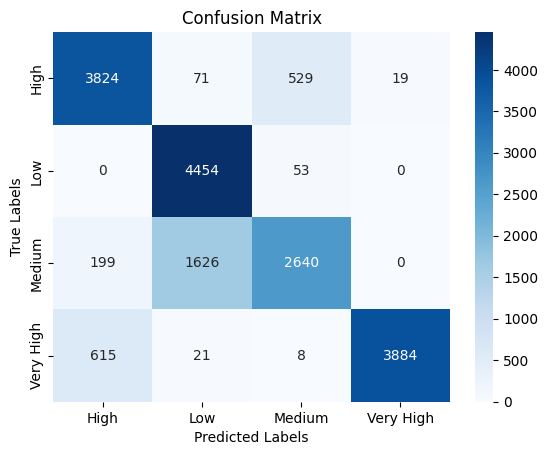

In [24]:
# Train an SVM model with a linear kernel
svm_model = SVC(kernel='linear', C=10, gamma='auto', random_state=0)
svm_model.fit(X_train_reduced, y_train_reduced)

# Evaluate the model,accuracy and confusion matrix
y_pred = svm_model.predict(X_test_reduced)
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test_reduced, y_pred)
print(f"Accuracy of the SVM(Linear) model: {accuracy}")
precision = precision_score(y_test_reduced, y_pred, average='micro')
print(f"Precision of the SVM(Linear) model: {precision}")
recall = recall_score(y_test_reduced, y_pred, average='micro')
print(f"Recall of the SVM(Linear) model: {recall}")
f1 = f1_score(y_test_reduced, y_pred, average='micro')
print(f"F1 Score of the SVM(Linear) model: {f1}")
#confusion matrix
cm = confusion_matrix(y_test_reduced, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Building the SVM rbf model

Accuracy of SVM(RBF): 0.5155771052778242
Precision of SVM(RBF): 0.5155771052778242
Recall of SVM(RBF): 0.5155771052778242
F1 Score of SVM(RBF): 0.5155771052778242


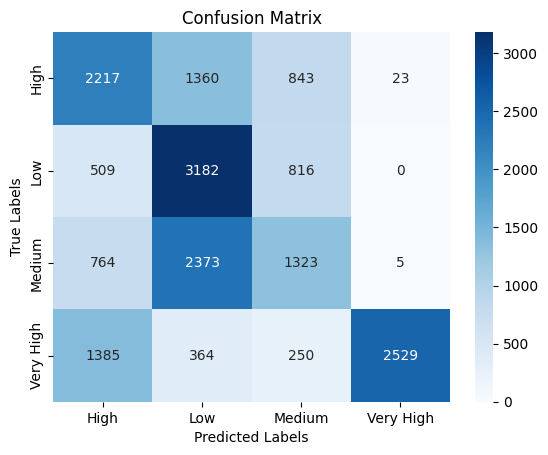

In [25]:
# Train an SVM model with a radial basis function (RBF) kernel
svm_model = SVC(kernel='rbf', C=10, gamma='auto', random_state=0)
svm_model.fit(X_train_reduced, y_train_reduced)

# Evaluate the model
y_pred = svm_model.predict(X_test_reduced)
accuracy = accuracy_score(y_test_reduced, y_pred)
print(f"Accuracy of SVM(RBF): {accuracy}")
precision = precision_score(y_test_reduced, y_pred, average='micro')
print(f"Precision of SVM(RBF): {precision}")
recall = recall_score(y_test_reduced, y_pred, average='micro')
print(f"Recall of SVM(RBF): {recall}")
f1 = f1_score(y_test_reduced, y_pred, average='micro')
print(f"F1 Score of SVM(RBF): {f1}")

cm = confusion_matrix(y_test_reduced, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


Building the SVM sigmoid model

Accuracy of SVM(Sigmoid): 0.25107284177673744
Precision of SVM(Sigmoid): 0.25107284177673744
Recall of SVM(Sigmoid): 0.25107284177673744
F1 Score of SVM(Sigmoid): 0.25107284177673744


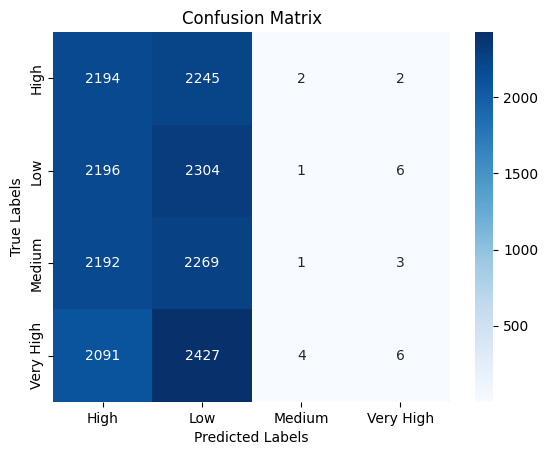

In [26]:

# Train an SVM model with a linear kernel
svm_model = SVC(kernel='sigmoid', C=1, gamma='auto', random_state=42)
svm_model.fit(X_train_reduced, y_train_reduced)

y_pred = svm_model.predict(X_test_reduced)

accuracy = accuracy_score(y_test_reduced, y_pred)
print(f"Accuracy of SVM(Sigmoid): {accuracy}")
precision = precision_score(y_test_reduced, y_pred, average='micro')
print(f"Precision of SVM(Sigmoid): {precision}")
recall = recall_score(y_test_reduced, y_pred, average='micro')
print(f"Recall of SVM(Sigmoid): {recall}")
f1 = f1_score(y_test_reduced, y_pred, average='micro')
print(f"F1 Score of SVM(Sigmoid): {f1}")

cm = confusion_matrix(y_test_reduced, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()



# Building the K-Nearest Neighbors Model(KNN)

KNN Accuracy: 0.7908200229610888
KNN Precision: 0.7908200229610888
KNN Recall: 0.7908200229610888
KNN F1 Score: 0.7908200229610888


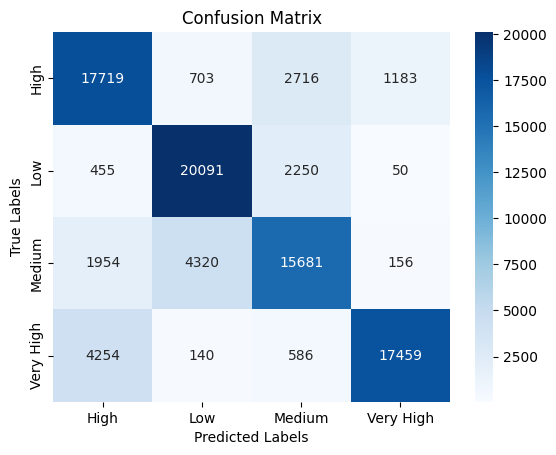

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Step 1: Initialize the KNN model with ball_tree algorithm
knn_model = KNeighborsClassifier(n_neighbors=5, metric='minkowski', algorithm='ball_tree')
knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN Accuracy: {accuracy_knn}")
precision_knn = precision_score(y_test, y_pred_knn, average='micro')
print(f"KNN Precision: {precision_knn}")
recall_knn = recall_score(y_test, y_pred_knn, average='micro')
print(f"KNN Recall: {recall_knn}")
f1_knn = f1_score(y_test, y_pred_knn, average='micro')
print(f"KNN F1 Score: {f1_knn}")
#confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Building the Random Forest Model

Random Forest Accuracy: 0.9965669828460604
Random Forest Precision: 0.9965669828460604
Random Forest Recall: 0.9965669828460604
Random Forest F1 Score: 0.9965669828460604


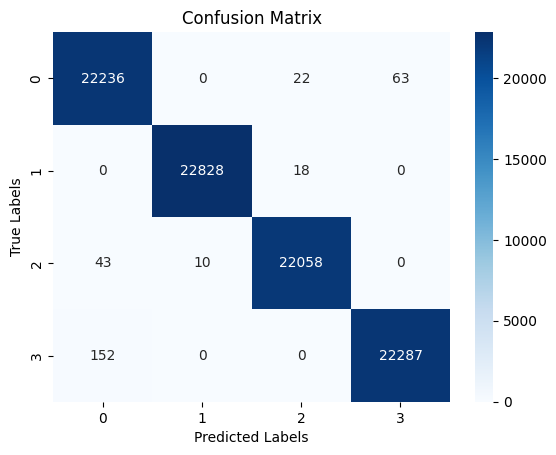

In [28]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest Classifier with hyperparameters for better performance
rf_model = RandomForestClassifier(n_estimators=200,max_depth=15,min_samples_split=10,random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy}")
precision = precision_score(y_test, y_pred, average='micro')
print(f"Random Forest Precision: {precision}")
recall = recall_score(y_test, y_pred, average='micro')
print(f"Random Forest Recall: {recall}")
f1 = f1_score(y_test, y_pred, average='micro')
print(f"Random Forest F1 Score: {f1}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

train_predictions = model.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)

test_predictions = model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Training Accuracy: 1.0000
Test Accuracy: 0.9980


In [30]:
import numpy as np
# Assuming 'all_cities_combined' is your DataFrame with feature names
feature_names = all_cities_combined.columns.tolist()  # Get the list of feature names
importances = model.feature_importances_  # Get the feature importances
indices = np.argsort(importances)[::-1]  # Sort indices by importance

print("Feature ranking:")
for f in range(len(importances)):  # Use len(importances) instead of X.shape[1]
    print(f"{f + 1}. {feature_names[indices[f]]} ({importances[indices[f]]:.4f})")

Feature ranking:
1. Uplink Traffic (0.4632)
2. Downlink Traffic (0.4521)
3. Duration (0.0569)
4. Location Area Code (0.0098)
5. Cell Identity (0.0095)
6. Date (0.0058)
7. Radio Access Type (RAT) (0.0017)
8. City (0.0010)


In [31]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X, y, cv=5)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f}")

Cross-Validation Scores: [0.76265368 0.99460526 0.99764813 0.99729145 0.99599848]
Mean CV Score: 0.9496


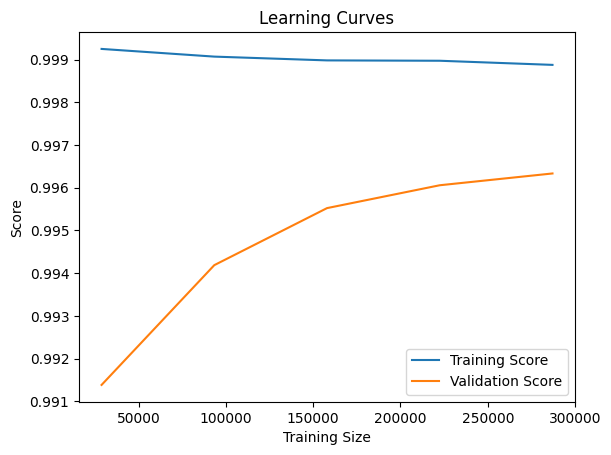

In [32]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(rf_model, X_train, y_train, cv=5)
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training Score')
plt.plot(train_sizes, test_scores_mean, label='Validation Score')
plt.title('Learning Curves')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend()
plt.show()

Based on the Cells of the Random Forest Model above the Accuracy of the model is 0.9965 which is very high but the model is overfitting.

Yes, it is **overfitting**

### Indicators:
1. **High Training Accuracy**: Close to 1.0.
2. **Gap Between Scores**: Training accuracy significantly higher than validation accuracy.
3. **Converging Curves**: Training and validation curves converge, but validation accuracy is lower.
4. **Cross-Validation Scores**: High mean score with variance, indicating inconsistency.

The model is likely overfitting due to the complexity of the Random Forest model. The model is too sensitive to the training data, leading to poor generalization.